In [50]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import geopandas as gpd
import warnings
from fuzzywuzzy import fuzz

# Ignore FutureWarning for plt part
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. Data Preprocessing

Dataset: 

![image]()

In [2]:
# Read csv
rb = pd.read_csv(".\\matched_beer_data\\ratings_with_text_rb.csv", sep = ",", header = 0)
ba = pd.read_csv(".\\matched_beer_data\\ratings_with_text_ba.csv", sep = ",", header = 0)

### 1.1 Delete Missing Values

Drop the rows with empty 'text'

In [3]:
ba_no_duplicates = ba.copy().drop_duplicates() 
ba_filtered = ba_no_duplicates.dropna(subset=['text'], how='all')
rb_no_duplicates = rb.copy().drop_duplicates()
rb_filtered = rb_no_duplicates.dropna(subset=['text'], how='all')

Calculate the number of reviews for each beer, and check the distribution of the number of reviews for different beers.

In [4]:
# Check reviews distribution for ba
ba_filtered_counts = ba_filtered['beer_id'].value_counts()
ba_filtered_counts = pd.DataFrame(data = ba_filtered_counts)
print(ba_filtered_counts.describe())

              count
count  28271.000000
mean      10.223126
std       53.640052
min        1.000000
25%        1.000000
50%        2.000000
75%        5.000000
max     2968.000000


In [5]:
#Check reviews distribution for rb
rb_filtered_counts = rb_filtered['beer_id'].value_counts()
rb_filtered_counts = pd.DataFrame(data = rb_filtered_counts)
print(rb_filtered_counts.describe())

              count
count  42228.000000
mean      24.168632
std       83.010641
min        1.000000
25%        2.000000
50%        5.000000
75%       18.000000
max     5270.000000


### 1.2 Data Filtering

- Drop the beer data with reviews less than 2 for sentiment analysis.

  For data in "RateBeer", 75% of the beers have more than 2 reviews, and for data in "BeerAdvocate", 75% of the beers have more than 1 reviews and 50% of the beers have more than 2 reviews. As a trade-off, we decide to set the threhold as 2. Because if we apply sentiment analysis to those beers with a few reviews,there might be high bias.

In [6]:
ba_filtered_counts = ba_filtered['beer_id'].value_counts()
# Drop the beer data with reviews less than 2 
beers_to_keep = ba_filtered_counts[ba_filtered_counts >= 2].index
mask = ba_filtered['beer_id'].isin(beers_to_keep)
filtered_data_ba = ba_filtered[mask]

rb_filtered_counts = rb_filtered['beer_id'].value_counts()
beers_to_keep = rb_filtered_counts[rb_filtered_counts >= 2].index
mask = rb_filtered['beer_id'].isin(beers_to_keep)
filtered_data_rb = rb_filtered[mask]

## 2. Discriptive Statistical Analysis and Visualization

### 2.1 Discriptive Statistical Analysis

### 2.2 Data Visualization

#### 2.2.1 Beer Review

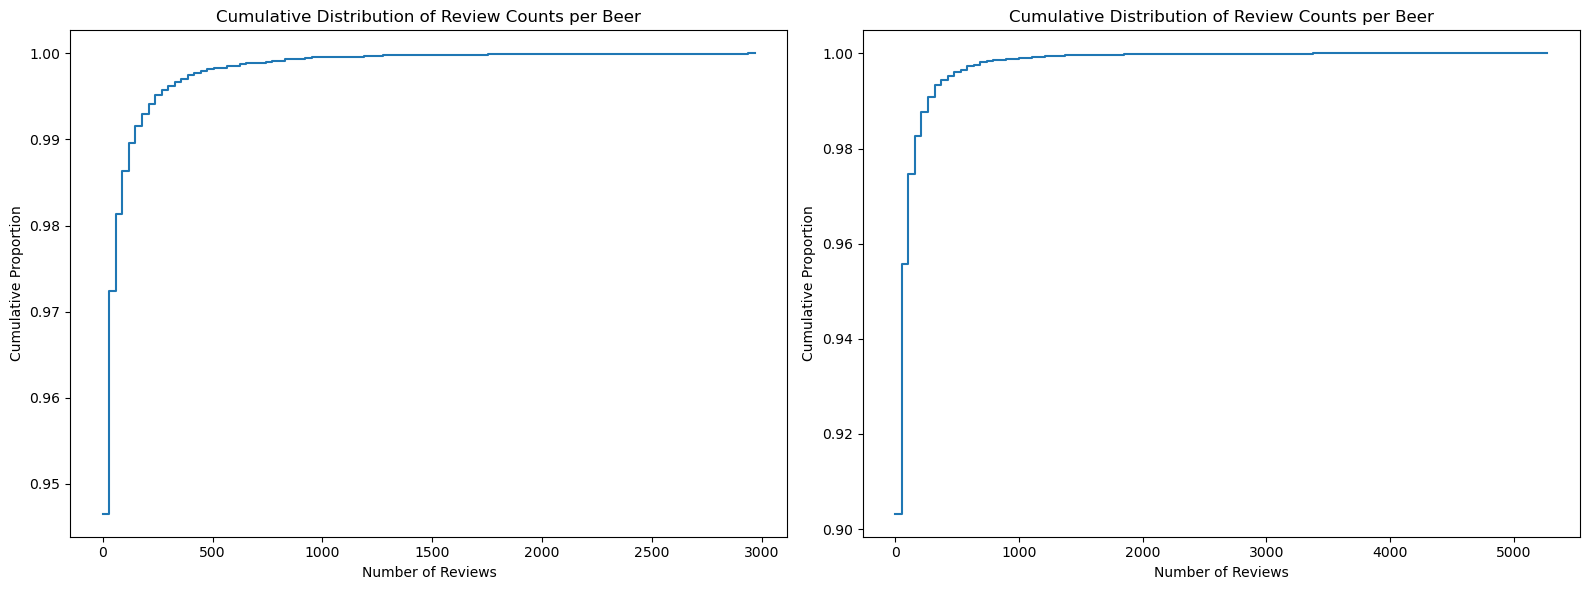

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Cumulative Distribution Plot (BA)
sns.histplot(ax=axes[0], data=ba_filtered_counts, bins=100, cumulative=True, stat="density", element="step", fill=False)
axes[0].set_title("Cumulative Distribution of Review Counts per Beer")
axes[0].set_xlabel("Number of Reviews")
axes[0].set_ylabel("Cumulative Proportion")

# Cumulative Distribution Plot (RB)
sns.histplot(ax=axes[1], data=rb_filtered_counts, bins=100, cumulative=True, stat="density", element="step", fill=False)
axes[1].set_title("Cumulative Distribution of Review Counts per Beer")
axes[1].set_xlabel("Number of Reviews")
axes[1].set_ylabel("Cumulative Proportion")

plt.tight_layout() 
plt.show()

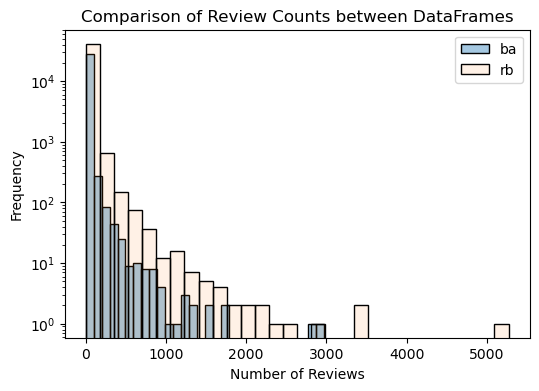

In [17]:
plt.figure(figsize=(6, 4))
sns.histplot(ba_filtered_counts, bins=30, label='ba',log_scale=(False, True), alpha=0.4)
sns.histplot(rb_filtered_counts, bins=30, label='rb',log_scale=(False, True), alpha=0.1)

plt.title('Comparison of Review Counts between DataFrames')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.legend()
plt.show()

beer style

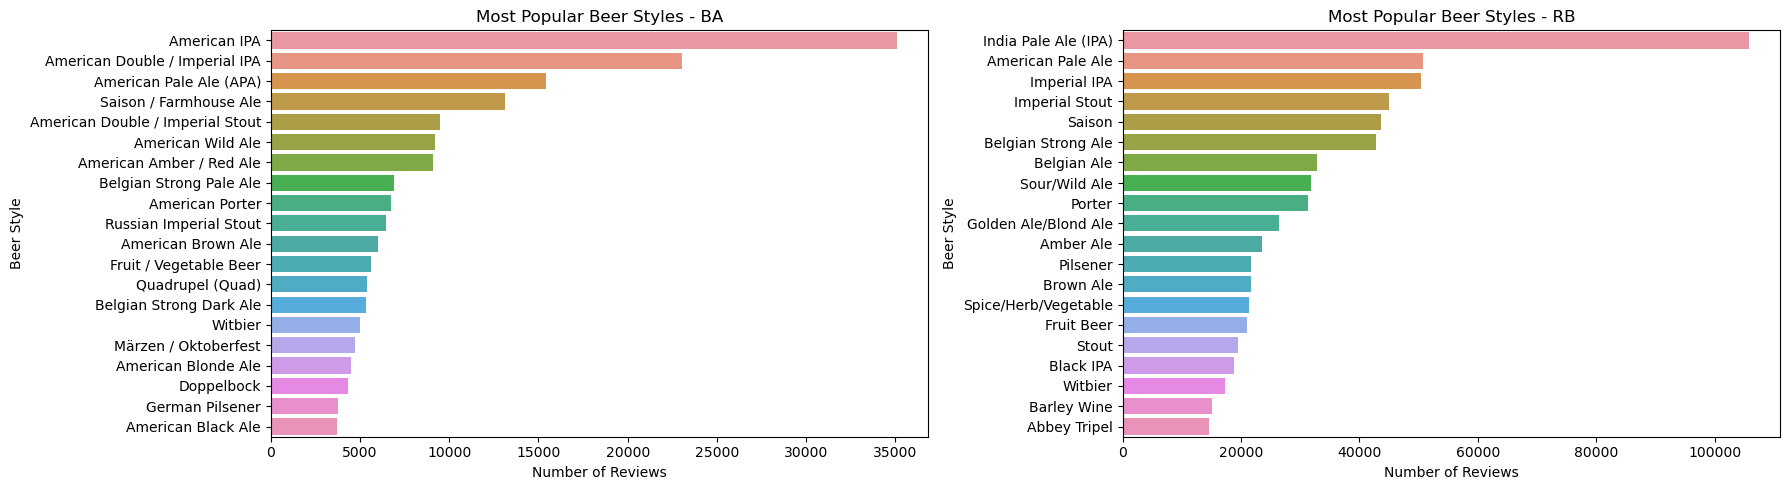

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Aggregate review counts by beer style for BA
style_counts_ba = ba_filtered['style'].value_counts()

# Select the top N styles for visualization
# Adjust the number (e.g., 20) to display more or fewer styles
top_styles_ba = style_counts_ba.head(20)
sns.barplot(ax=axes[0], x=top_styles_ba.values, y=top_styles_ba.index)
axes[0].set_title('Most Popular Beer Styles - BA')
axes[0].set_xlabel('Number of Reviews')
axes[0].set_ylabel('Beer Style')


# Aggregate review counts by beer style for RB
style_counts_rb = rb_filtered['style'].value_counts()

# Select the top N styles for visualization
# Adjust the number (e.g., 20) to display more or fewer styles
top_styles_rb = style_counts_rb.head(20)
sns.barplot(ax=axes[1], x=top_styles_rb.values, y=top_styles_rb.index)
axes[1].set_title('Most Popular Beer Styles - RB')
axes[1].set_xlabel('Number of Reviews')
axes[1].set_ylabel('Beer Style')

plt.tight_layout() 
plt.show()

#### 2.2.2 User Data

location

In [51]:
file_path = '.\\matched_beer_data\\users.csv'  
df = pd.read_csv(file_path)
df = df.drop(df.index[0])
 

In [53]:
location = []
for item1 in df['rb.1'].values:
    closest_match = None
    highest_similarity = 0
    for item2 in world['name'].values:
        similarity = fuzz.ratio(item1, item2)
        if similarity > highest_similarity:
            closest_match = item2
            highest_similarity = similarity
    location.append(closest_match)
    
df['location'] = location
print(df['location'] )

1                        Germany
2       United States of America
3       United States of America
4                        Estonia
5                        Finland
                  ...           
3016    United States of America
3017    United States of America
3018    United States of America
3019                     Vietnam
3020                      Sweden
Name: location, Length: 3020, dtype: object


In [56]:
# 假设 df 是你的 DataFrame，'Column_Name' 是你要查看唯一值的列名
unique_values = df['location'].unique()

# 打印唯一值
print(unique_values)

['Germany' 'United States of America' 'Estonia' 'Finland' 'Spain'
 'Netherlands' 'Belarus' 'Switzerland' 'Canada' 'Poland' 'Norway' 'Sweden'
 'Mexico' 'Czechia' 'Slovenia' 'Belgium' 'Thailand' 'Australia' 'Malaysia'
 'Greece' 'Russia' 'El Salvador' 'Denmark' 'Croatia' 'Moldova' 'Brazil'
 'Uruguay' 'Austria' 'Italy' 'Turkey' 'South Africa' 'Peru' 'Romania'
 'Bulgaria' 'Hungary' 'Lithuania' 'Philippines' 'France' 'Puerto Rico'
 'Argentina' 'Suriname' 'Portugal' 'Mauritania' 'Taiwan' 'Japan' 'Ukraine'
 'Panama' 'Paraguay' 'Israel' 'Serbia' 'Belize' 'Ireland' 'China' 'India'
 'Lebanon' 'Chile' 'Vietnam']


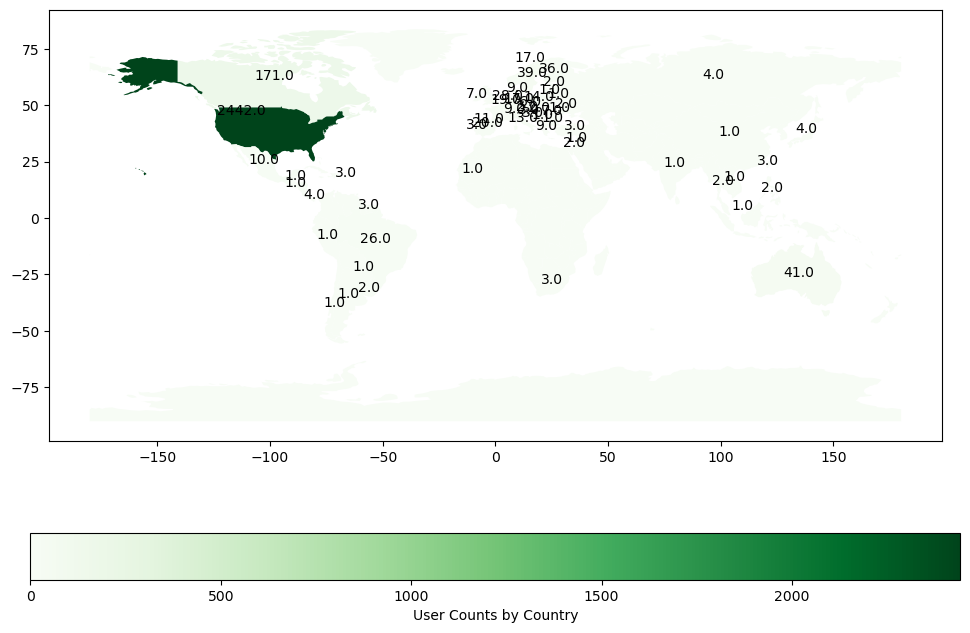

In [68]:
user_counts = df['location'].value_counts().reset_index()
user_counts.columns = ['country', 'count']

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge world map data and user count data
# Note: Some adjustments may need to be made here based on the specific situation of the country names in your data set.
world = world.merge(user_counts, how='left', left_on='name', right_on='country')

# Regions with NaN number of users are set to 0
world['count'] = world['count'].fillna(0)

# Draw map
world.plot(column='count', cmap='Greens', figsize=(12, 8), legend=True,
           legend_kwds={'label': "User Counts by Country",
                        'orientation': "horizontal"})
for idx, row in world.iterrows():
    count_value = row['count']
    if count_value != 0:  
        plt.annotate(text=count_value, xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                     horizontalalignment='center')

plt.show()

#### 2.2.3 Review Data

ratings

- Beer Ratings

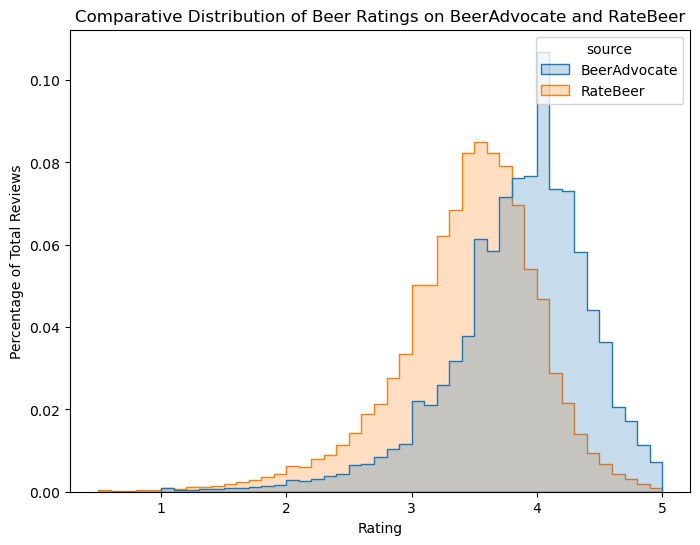

In [71]:
ba_filtered.loc[:, 'source'] = 'BeerAdvocate'
rb_filtered.loc[:, 'source'] = 'RateBeer'
all_reviews = pd.concat([ba_filtered, rb_filtered], ignore_index=True)

plt.figure(figsize=(8, 6))
sns.histplot(data=all_reviews[['rating', 'source']], 
             x='rating', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.1)
plt.title("Comparative Distribution of Beer Ratings on BeerAdvocate and RateBeer")
plt.xlabel("Rating")
plt.ylabel("Percentage of Total Reviews")
plt.show()

- Beer Ratings(standardization)

In [73]:
# Rating standerlization for filtered_data_ba.
mean_rating = ba_filtered['rating'].mean()
std_rating = ba_filtered['rating'].std()
# Standardize the 'ratings' column
ba_filtered.loc[:, 'standardized_ratings'] = (ba_filtered['rating'] - mean_rating) / std_rating

# Rating standerlization for filtered_data_rb.
mean_rating = rb_filtered['rating'].mean()
std_rating = rb_filtered['rating'].std()
# Standardize the 'ratings' column
rb_filtered.loc[:, 'standardized_ratings'] = (rb_filtered['rating'] - mean_rating) / std_rating

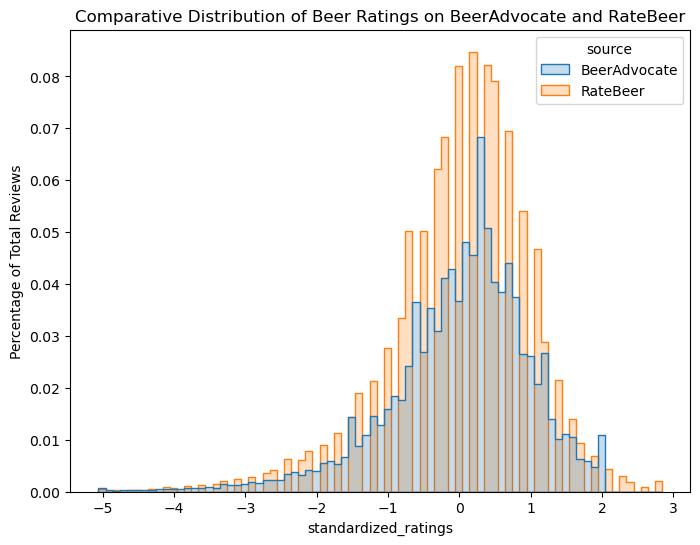

In [74]:
all_reviews_std = pd.concat([ba_filtered, rb_filtered], ignore_index=True)
plt.figure(figsize=(8, 6))
sns.histplot(data=all_reviews_std[['standardized_ratings', 'source']], 
             x='standardized_ratings', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.1)
plt.title("Comparative Distribution of Beer Ratings on BeerAdvocate and RateBeer")
plt.xlabel("standardized_ratings")
plt.ylabel("Percentage of Total Reviews")
plt.show()

In [ ]:
chracteristic(apperance....) single graph for all subgraph

C:\Users\ROG\AppData\Local\Temp\ipykernel_30304\1173559343.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rb_filtered.loc[:,'standardized_aroma'] = (rb_filtered['aroma'] - mean_aroma) / std_aroma
C:\Users\ROG\AppData\Local\Temp\ipykernel_30304\1173559343.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ba_filtered.loc[:, 'standardized_taste'] = (ba_filtered['taste'] - mean_taste) / std_taste
C:\Users\ROG\AppData\Local\Temp\ipykernel_30304\1173559343.py:67: SettingWithCopyWarning: 
A value is tryin

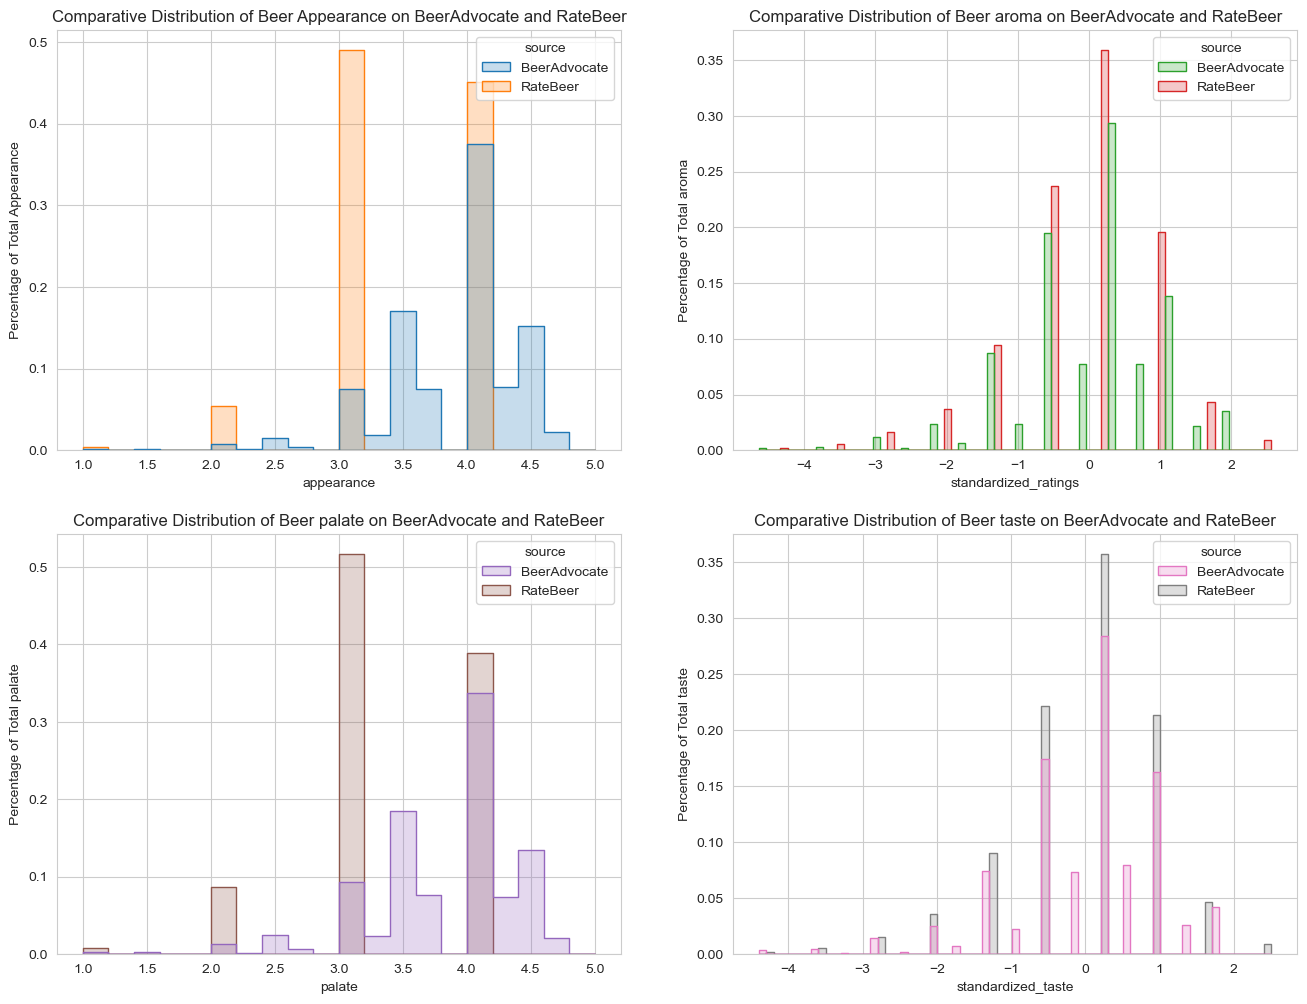

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [80]:
# 设置整体风格
sns.set_style("whitegrid")

# 创建一个2x2的子图布局
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 定义四组颜色，每组用于一个子图
palette1 = ["#1f77b4", "#ff7f0e"]  # taste
palette2 = ["#2ca02c", "#d62728"]  # palate
palette3 = ["#9467bd", "#8c564b"]  # aroma
palette4 = ["#e377c2", "#7f7f7f"]  # appearance

# 1.appearance
sns.histplot(data=all_reviews[['appearance', 'source']], 
             x='appearance', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.2, ax=axes[0, 0], palette=palette1)
axes[0, 0].set_title("Comparative Distribution of Beer Appearance on BeerAdvocate and RateBeer")
axes[0, 0].set_xlabel("appearance")
axes[0, 0].set_ylabel("Percentage of Total Appearance")


# 2.aroma
# aroma standerlization for filtered_data_ba.
mean_aroma = ba_filtered['aroma'].mean()
std_aroma = ba_filtered['aroma'].std()
# Standardize the 'aroma' column
ba_filtered.loc[:,'standardized_aroma'] = (ba_filtered['aroma'] - mean_aroma) / std_aroma

# Rating standerlization for filtered_data_rb.
mean_aroma = rb_filtered['aroma'].mean()
std_aroma = rb_filtered['aroma'].std()
# Standardize the 'ratings' column
rb_filtered.loc[:,'standardized_aroma'] = (rb_filtered['aroma'] - mean_aroma) / std_aroma
all_aroma_std = pd.concat([ba_filtered, rb_filtered], ignore_index=True)

plt.figure(figsize=(8, 6))
sns.histplot(data=all_aroma_std[['standardized_aroma', 'source']], 
             x='standardized_aroma', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.1, ax=axes[0, 1], palette=palette2)
axes[0, 1].set_title("Comparative Distribution of Beer aroma on BeerAdvocate and RateBeer")
axes[0, 1].set_xlabel("standardized_ratings")
axes[0, 1].set_ylabel("Percentage of Total aroma")

# 3.palate

sns.histplot(data=all_reviews[['palate', 'source']], 
             x='palate', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.2, ax=axes[1, 0], palette=palette3)
axes[1, 0].set_title("Comparative Distribution of Beer palate on BeerAdvocate and RateBeer")
axes[1, 0].set_xlabel("palate")
axes[1, 0].set_ylabel("Percentage of Total palate")

# 4.taste
# taste standerlization for filtered_data_ba.
mean_taste = ba_filtered['taste'].mean()
std_taste = ba_filtered['taste'].std()
# Standardize the 'taste' column
ba_filtered.loc[:, 'standardized_taste'] = (ba_filtered['taste'] - mean_taste) / std_taste

# taste standerlization for filtered_data_rb.
mean_taste = rb_filtered['taste'].mean()
std_taste = rb_filtered['taste'].std()
# Standardize the 'taste' column
rb_filtered.loc[:,'standardized_taste'] = (rb_filtered['taste'] - mean_taste) / std_taste

all_taste_std = pd.concat([ba_filtered, rb_filtered], ignore_index=True)
plt.figure(figsize=(8, 6))
sns.histplot(data=all_taste_std[['standardized_taste', 'source']], 
             x='standardized_taste', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.1, ax=axes[1, 1], palette=palette4)
axes[1, 1].set_title("Comparative Distribution of Beer taste on BeerAdvocate and RateBeer")
axes[1, 1].set_xlabel("standardized_taste")
axes[1, 1].set_ylabel("Percentage of Total taste")

plt.tight_layout()

wordcloud

In [79]:
texts = filtered_data_ba['text']
#Add more personalized stopwords
additional_stopwords = {'beer', 'beers'}
stopwords = set(STOPWORDS).union(additional_stopwords)

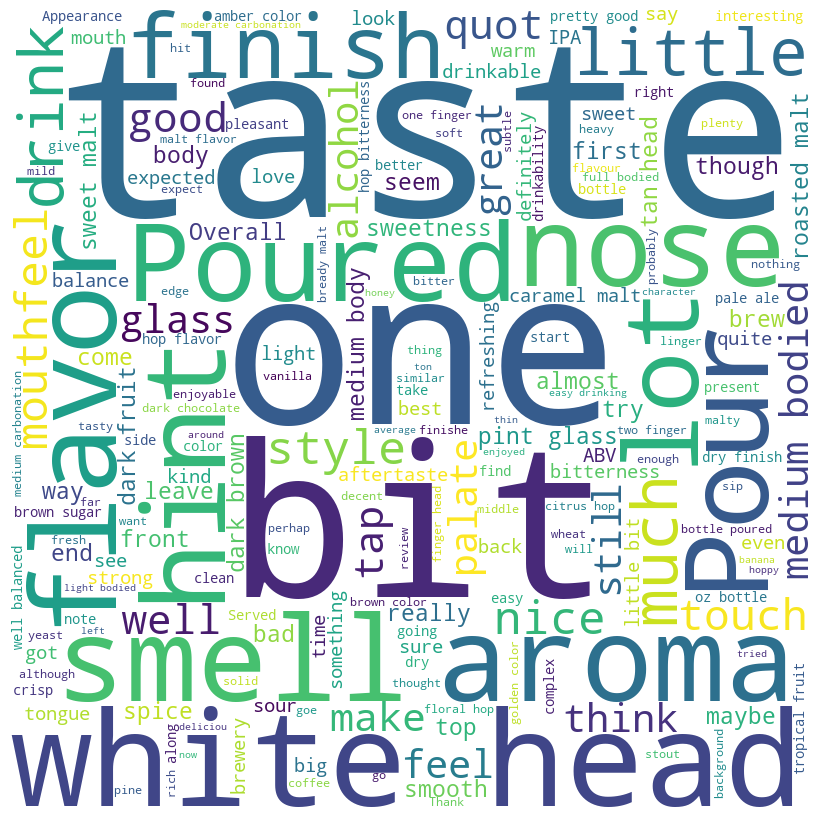

CPU times: total: 40 s
Wall time: 42.4 s


In [183]:
%%time

beer_can_image = 'C:\\Users\\ROG\\Desktop\\VK750.jpg'
mask = np.array(Image.open(beer_can_image))


wordcloud = WordCloud(
    width = 800, height = 800, 
    background_color ='white', 
    stopwords = stopwords, 
    min_font_size = 10,
)

wordcloud.generate(' '.join(texts))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

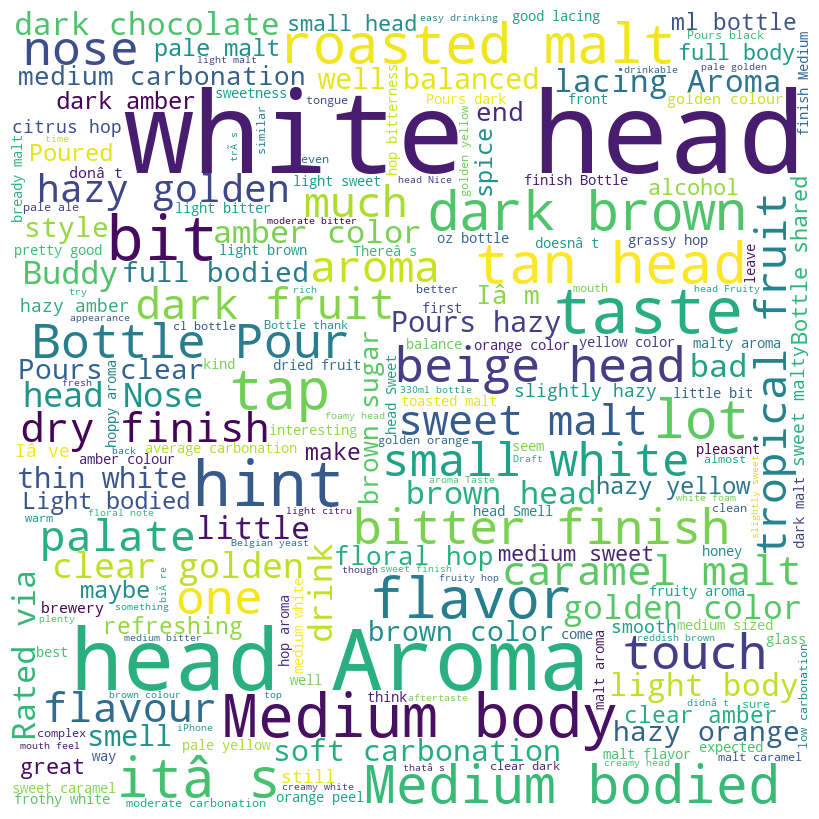

CPU times: total: 1min 25s
Wall time: 1min 31s


In [138]:
%%time

beer_can_image = '..\\Desktop\\VK750.jpg'
mask = np.array(Image.open(beer_can_image))


wordcloud = WordCloud(
    width = 800, height = 800, 
    background_color ='white', 
    stopwords = stopwords, 
    min_font_size = 10,
)

wordcloud.generate(' '.join(texts))*

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()